In [414]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy import abs, mean, max, real, imag, sqrt
from numpy.linalg import eigvals
#import pandas as pd
import xarray as xr

from rate_model import RateModelWC
from utils import json_safe

In [415]:
SEED = 113
np.random.seed(SEED)

N = 2
nw = 100
ws = 1

# Sample mats
Wpool = ws * (2 * np.random.rand(nw, N, N) - 1)

# Calculate W eigenvalues
L = np.zeros((nw, N), dtype=np.complex128)
for n in range(nw):
    W = Wpool[n, :, :]
    L[n, :] = np.linalg.eigvals(W)

# Sort Wpool and L based on max(real(L))
idx = np.argsort(np.max(np.real(L), axis=1))
Wpool = Wpool[idx, :, :]
L = L[idx, :]

In [416]:
# Sample r0 uniformly and derive h0
def sample_pts_by_r(model_, npts_, r0_margin_):
    N_ = model_.npops
    # Range of r0
    r0_range = [[r0_margin_, model_.rmax[m] - r0_margin_]
                for m in range(N_)]
    # Random sample
    R = np.random.uniform(0, 1, (N_, npts_))
    # Rescale the sample to r0 range
    for m in range(N_):
        R[m, :] = R[m, :] * (r0_range[m][1] - r0_range[m][0]) + r0_range[m][0]
    # Project r0 to h0
    H = np.zeros_like(R)
    for n in range(npts_):
        H[:, [n]] = model_.r0_to_h0(R[:, n])
    return R, H

# Sample mu0 uniformly, derive r0 and h0
def sample_pts_by_mu(model_, npts_, r0_margin_):
    N_ = model_.npops
    # Range of r0
    r0_range = [[r0_margin_, model_.rmax[m] - r0_margin_]
                for m in range(N_)]
    # Range of mu0
    mu0_range = [[model_.gain_inv(r0_range[m][k], m) for k in range(2)]
                 for m in range(N_)]
    # Random sample
    mu_mat = np.random.uniform(0, 1, (N_, npts_))
    # Rescale the sample to mu0 range
    for m in range(N_):
        mu_mat[m, :] = (mu_mat[m, :] * (mu0_range[m][1] - mu0_range[m][0])
                        + mu0_range[m][0])
    # Project mu0 to r0
    R = model_.gain(mu_mat)
    # Project r0 to h0
    H = np.zeros_like(R)
    for n in range(npts_):
        H[:, [n]] = model_.r0_to_h0(R[:, n])
    return R, H

In [417]:
w_id_sel = 2

# Choose a matrix
W = Wpool[-w_id_sel, :, :]

# Initialize model
model_par = dict(tau=1, rmax=10, gain_slope=0.5, gain_center=0)
model = RateModelWC(W, **model_par)

npts = 2500
r0_margin = 0.01

Rr, Hr = sample_pts_by_r(model, npts, r0_margin)
Rmu, Hmu = sample_pts_by_mu(model, npts, r0_margin)
R = np.concatenate((Rr, Rmu), axis=1)
H = np.concatenate((Hr, Hmu), axis=1)
npts *= 2

# Calculate J eigenvalues
Lj = np.zeros((N, npts), dtype=np.complex128)
for n in range(npts):
    J = model.get_J(R[:, n], H[:, n])
    Lj[:, n] = eigvals(J)

In [419]:
# Sort R, H, Lj based on max(real(Lj))
idx = np.argsort(np.max(np.real(Lj), axis=0))[::-1]
R = R[:, idx]
H = H[:, idx]
Lj = Lj[:, idx]

Lj_remax = np.max(np.real(Lj), axis=0)
np.round(Lj_remax[:10], 3)

array([0.775, 0.775, 0.774, 0.774, 0.774, 0.774, 0.773, 0.772, 0.772,
       0.772])

In [420]:
def plot_nullclines(model, h0):

    # Define the activation (gain) function used in the model dynamics.
    rmax, gain_slope, gain_center = model.rmax, model.gain_slope, model.gain_center
    def gain(u, n):
        return rmax[n] / (1 + np.exp(-gain_slope[n] * (u - gain_center[n])))

    # Create a grid of firing rates for the two populations.
    r0_vals = np.linspace(0, rmax[0], 300)
    r1_vals = np.linspace(0, rmax[1], 300)
    R0, R1 = np.meshgrid(r0_vals, r1_vals)

    # Compute the nullcline functions for each population.
    # The dynamics is assumed to be: dr/dt ~= -r + gain(W @ r + h0)
    W = model.W
    f0 = -R0 + gain(W[0, 0] * R0 + W[0, 1] * R1 + h0[0], 0)
    f1 = -R1 + gain(W[1, 0] * R0 + W[1, 1] * R1 + h0[1], 1)

    # Plot the nullclines (contours where f0=0 and f1=0).
    plt.contour(R0, R1, f0, levels=[0], colors='b', linewidths=2)
    plt.contour(R0, R1, f1, levels=[0], colors='r', linewidths=2)
    plt.xlabel('r1')
    plt.ylabel('r2')
    plt.title('Nullclines')

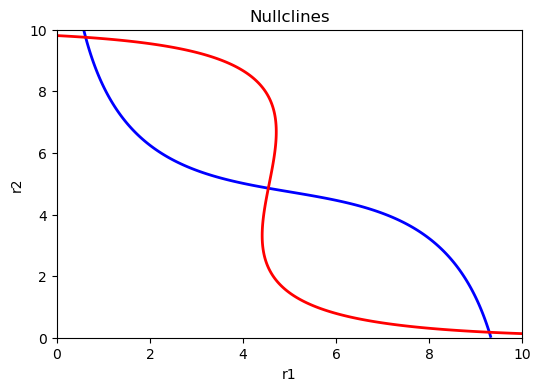

In [421]:
h = H[:, 20]

plt.figure(figsize=(6, 4))
plot_nullclines(model, h)

Text(0, 0.5, 'h2')

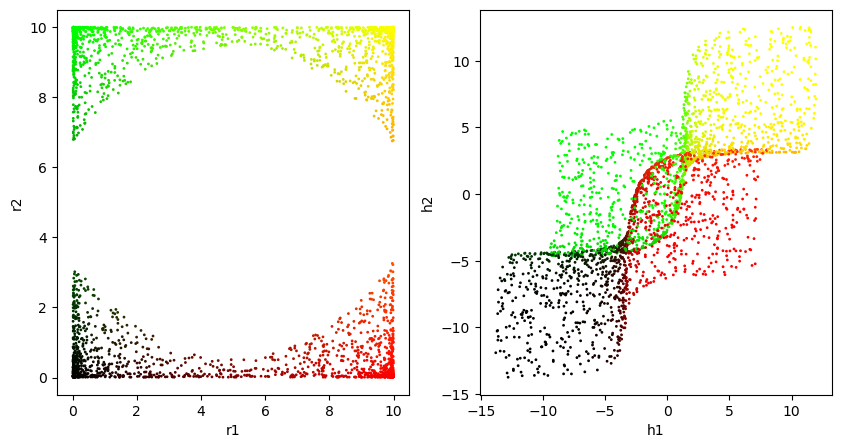

In [423]:
cols = np.clip(R / model.rmax, 0, 1).T
cols = np.hstack((cols, np.zeros((cols.shape[0], 1))))

s = 1

plt.figure(figsize=(10, 5))
mask = Lj_remax < 0
plt.subplot(1, 2, 1)
plt.scatter(R[0, mask], R[1, mask], s=s, c=cols[mask])
#plt.scatter(R[0, :], R[1, :], s=Lj_remax * 7)
plt.xlabel('r1')
plt.ylabel('r2')
plt.subplot(1, 2, 2)
plt.scatter(H[0, mask], H[1, mask], s=s, c=cols[mask])
#plt.scatter(H[0, :], H[1, :], s=Lj_remax * 7)
plt.xlabel('h1')
plt.ylabel('h2')

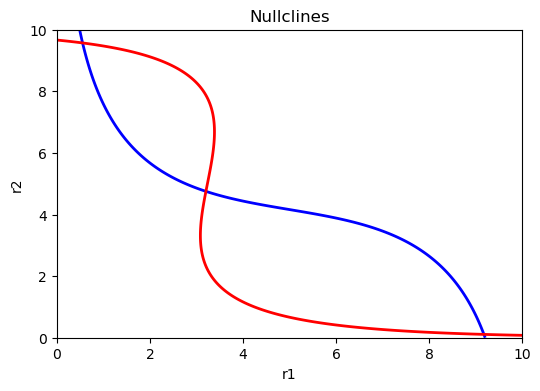

In [424]:
h = [-1.3, -2]

plt.figure(figsize=(6, 4))
plot_nullclines(model, np.array(h))

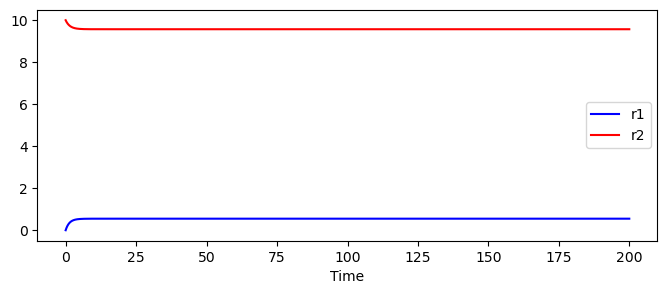

In [425]:
rstart = [0, 10]

# Simulate the model
T = 200
dt = 0.02
model.sim_res_type = 'full'
Rsim = model.run(np.array(h, dtype=float),
                 r0=np.array(rstart, dtype=float),
                 dt=dt, nsteps=int(T / dt))

plt.figure(figsize=(8, 3))
cols2 = ['b', 'r']
for pop in range(N):
    plt.plot(Rsim.time, Rsim.sel(pop=pop), cols2[pop])
plt.xlabel('Time')
plt.legend(['r1', 'r2'])

In [428]:
mask = Lj_remax < 0
R_ = R[:, mask]
H_ = H[:, mask]
npts_ = R_.shape[1]

X = xr.Dataset(
    {
        'H': (['point', 'pop'], H_.T),
        'R': (['point', 'pop'], R_.T)
    },
    coords={
        'point': np.arange(npts_),
        'pop': np.arange(N)
    }
)

fname_out = (f'rates_ws_{ws}_nw_{nw}_wsel_{w_id_sel}_npts_{npts}_'
             f'rmarg_{r0_margin}_seed_{SEED}.nc')

# Save the dataset to a NetCDF file
X.to_netcdf(Path().resolve().parent / 'data' / 'rates_2pop_1mat' / fname_out)

In [429]:
data = xr.open_dataset(
    Path().resolve().parent / 'data' / 'rates_2pop_1mat' / fname_out)
print(data)
data.close()

<xarray.Dataset> Size: 99kB
Dimensions:  (point: 2736, pop: 2)
Coordinates:
  * point    (point) int32 11kB 0 1 2 3 4 5 6 ... 2730 2731 2732 2733 2734 2735
  * pop      (pop) int32 8B 0 1
Data variables:
    H        (point, pop) float64 44kB ...
    R        (point, pop) float64 44kB ...
